For this assignment, use the ERA-5 *monthly mean* data at NCAR (DOI: 10.5065/P8GT-0R61) as we did in Module 2.  Feel free to reduce the data to 1 degree resolution if you need to save data download times.


1) Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and total column water vapor from Jan 1979-Dec 2023 over the Pacific Basin (65°N to 65°S, 120°E to 60°W) masked out over land - save this to your computer. The land sea mask is available here: [https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc](https://thredds.rda.ucar.edu/thredds/catalog/files/g/ds633.0/e5.oper.invariant/197901/catalog.html?dataset=files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc)

*Skill check in:* due Friday, Mar 1, end of day to slack: Plot maps of the mean SST and mean total column water vapor for the entire period of record.

2)  From the dataset shown in 1, compute anomalies by deseasonalizing the data (remove the mean monthly anomaly from the annual mean from each point), detrend, and standardize the SST anomalies.  Standardization means subtract the long term mean and divide by the standard deviation, which can be accomplished using the methods described here: [6.3. Preprocessing data &mdash; scikit-learn 1.1.2 documentation](https://scikit-learn.org/stable/modules/preprocessing.html)
   
   Hints: [Monthly data analysis &#8212; PyCLIM_101 0.2 documentation](https://climate.usu.edu/people/yoshi/pyclm101/monthly.html)

3) Perform an EOF analysis (with cosine latitude weighting) on the SST anomalies and plot a map of the first 5 EOFs.

4) Plot the percent of variance explained by the first 10 EOFs.

5) Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient ([xarray.corr](https://docs.xarray.dev/en/stable/generated/xarray.corr.html)) of the reconstructed monthly time series and the "observed" SST time series.

6) Compute a map of the Pearson's correlation coefficient between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean precipitation anomalies (don't mask these over land for the plot).  See anything interesting?

In [30]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

In [31]:
# ds = xr.open_dataset('https://thredds.rda.ucar.edu/thredds/dodsC/aggregations/g/ds633.1/2/TP',
#                      chunks={'time':'500MB'})

# variables = ['Total_column_water_vapour_surface_Mixed_intervals_Average',
#         'Sea_surface_temperature_surface_Mixed_intervals_Average']

# #select the two needed variables every 4th point to get 1 degree resolution
# ds = ds[variables].sel(lat=slice(65, -65, 4), lon=slice(120, 300, 4))

# # Rounding lat to 2 decimal places
# latitudes = np.round(ds['lat'], 2)

# # Create a new DataArray with rounded latitudes
# rounded_latitudes = xr.DataArray(latitudes, dims='lat', coords={'lat': ds['lat']})

# # Replace the latitude coordinates in the existing DataArray
# ds['lat'] = rounded_latitudes

# # Saving data to file
# ds.to_netcdf('raw_data.nc')

# Loading filtered data
data = xr.open_dataset('raw_data.nc')

In [32]:
# OPeNDAP URL for land sea mask
url = 'https://thredds.rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc'

# Open dataset with setting engine to netcdf
mask_data = xr.open_dataset(url, engine='netcdf4')

# to only have the LSM variable
mask = mask_data['LSM']

# select the needed variables every 4th point to get 1 degree resolution
mask = mask.sel(latitude=slice(64.75, -64.75, 4), longitude=slice(120, 300, 4))

# Rename the coordinates
mask = mask.rename({'latitude': 'lat', 'longitude': 'lon'})

# Making the mask have no time dimension and only being true and false values
mask = (mask == 0).squeeze(['time'], drop=True)

In [33]:
# Replace land values with NaN in the data
data.where(mask == 0)

<xarray.Dataset>
Dimensions:                                                    (time: 516,
                                                                lat: 130,
                                                                lon: 181)
Coordinates:
  * lat                                                        (lat) float32 ...
  * lon                                                        (lon) float32 ...
  * time                                                       (time) datetime64[ns] ...
    reftime                                                    (time) datetime64[ns] ...
Data variables:
    Total_column_water_vapour_surface_Mixed_intervals_Average  (time, lat, lon) float32 ...
    Sea_surface_temperature_surface_Mixed_intervals_Average    (time, lat, lon) float32 ...
Attributes:
    Originating_or_generating_Center:     European Centre for Medium Range We...
    Originating_or_generating_Subcenter:  0
    GRIB_table_version:                   0,128
    file_format:                          GRIB-1
    Conventions:                          CF-1.6
    history:                              Read using CDM IOSP GribCollection v3
    featureType:                          GRID
    _CoordSysBuilder:                     ucar.nc2.dataset.conv.CF1Convention

In [34]:
# Creating time series 
mean_data = data.mean(dim=['lat', 'lon'])
mean_data

<xarray.Dataset>
Dimensions:                                                    (time: 516)
Coordinates:
  * time                                                       (time) datetime64[ns] ...
    reftime                                                    (time) datetime64[ns] ...
Data variables:
    Total_column_water_vapour_surface_Mixed_intervals_Average  (time) float32 ...
    Sea_surface_temperature_surface_Mixed_intervals_Average    (time) float32 ...

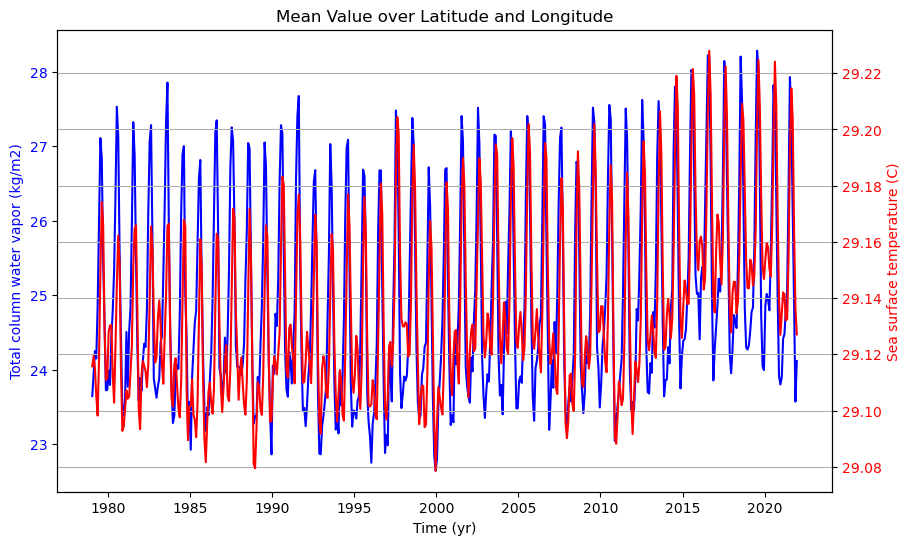

In [35]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Line plot for the first y-axis
ax1.plot(mean_data['time'], mean_data['Total_column_water_vapour_surface_Mixed_intervals_Average'], color='blue', label='Total column water vapour')
ax1.set_xlabel('Time (yr)')
ax1.set_ylabel('Total column water vapor (kg/m2)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Creating secondary y-axis
ax2 = ax1.twinx()
ax2.plot(mean_data['time'], mean_data['Sea_surface_temperature_surface_Mixed_intervals_Average']/10, color='red', label='Sea surface temperature')
ax2.set_ylabel('Sea surface temperature (C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Mean Value over Latitude and Longitude')
plt.grid(True)
plt.show()

## Part 2

2)  From the dataset shown in 1, compute anomalies by deseasonalizing the data (remove the mean monthly anomaly from the annual mean from each point), detrend, and standardize the SST anomalies.  Standardization means subtract the long term mean and divide by the standard deviation, which can be accomplished using the methods described here: [6.3. Preprocessing data &mdash; scikit-learn 1.1.2 documentation](https://scikit-learn.org/stable/modules/preprocessing.html)

In [36]:
# Grouping data into months to find mean over each point
climatology = data.sel(time=slice('1980-01-01','2010-12-01')).groupby('time.month').mean(dim='time')

# removing the mean monthly anomaly form the annual mean for each point 
anomalies = (data.groupby('time.month')-climatology)

In [37]:
# -- Detrending
def detrend_dataset(ds, dim, deg=1):
    # detrend each data variable along the specified dimension
    detrended_ds = xr.Dataset()
    for var in ds.data_vars:
        da = ds[var]
        p = da.polyfit(dim=dim, deg=deg)
        fit = xr.polyval(da[dim], p.polyfit_coefficients)
        detrended_ds[var] = da - fit
    return detrended_ds

ranm = anomalies.rolling(time=12, center=True).mean('time')
rdanm = detrend_dataset(ranm, 'time', 1)

In [38]:
# standardize the SST anomalies.  Standardization means subtract the long term mean and divide by the standard deviation

standardize = rdanm / rdanm.std(dim='time')

/Users/garrickhague/opt/anaconda3/envs/pythia/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


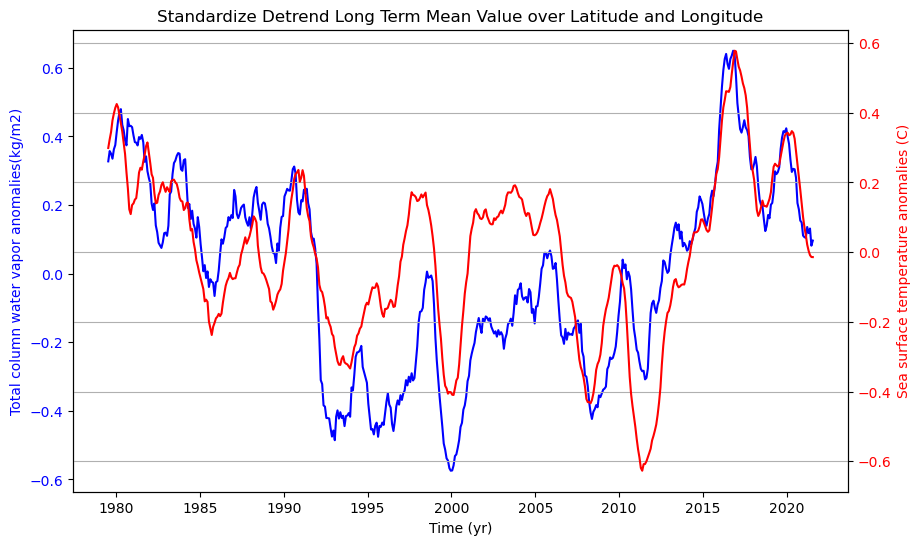

In [39]:
s_m = standardize.mean(dim=['lat', 'lon'])

fig, ax1 = plt.subplots(figsize=(10, 6))

# Line plot for the first y-axis
ax1.plot(s_m['time'], s_m['Total_column_water_vapour_surface_Mixed_intervals_Average'], color='blue', label='Total column water vapour')
ax1.set_xlabel('Time (yr)')
ax1.set_ylabel('Total column water vapor anomalies(kg/m2)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Creating secondary y-axis
ax2 = ax1.twinx()
ax2.plot(s_m['time'], s_m['Sea_surface_temperature_surface_Mixed_intervals_Average'], color='red', label='Sea surface temperature')
ax2.set_ylabel('Sea surface temperature anomalies (C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Standardize Detrend Long Term Mean Value over Latitude and Longitude')
plt.grid(True)
plt.show()

# 
3) Perform an EOF analysis (with cosine latitude weighting) on the SST anomalies and plot a map of the first 5 EOFs.


In [40]:
# -- regional average
def wgt_areaave(indat, latS, latN, lonW, lonE):
  lat=indat.lat
  lon=indat.lon

  if ( ((lonW < 0) or (lonE < 0 )) and (lon.values.min() > -1) ):
     anm=indat.assign_coords(lon=( (lon + 180) % 360 - 180) )
     lon=( (lon + 180) % 360 - 180) 
  else:
     anm=indat

  iplat = lat.where( (lat >= latS ) & (lat <= latN), drop=True)
  iplon = lon.where( (lon >= lonW ) & (lon <= lonE), drop=True)
  
  wgt = np.cos(np.deg2rad(lat))
  odat=anm.sel(lat=iplat,lon=iplon).weighted(wgt).mean(("lon", "lat"), skipna=True)
  return(odat)

  wgt_standard = wgt_areaave(standardize, -64.75, 64.75, 120, 300)